<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# Practicum Project: Bincentive

## Pairtrading: Version 0404-2 ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Also Using FF5 Assets

## Basic Import

In [28]:
import os
import ccxt
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import warnings 
warnings.filterwarnings('ignore')
import itertools
from sklearn.preprocessing import Normalizer


## Basic Defination 

In [2]:

def Delete_all_CSV(i):
    pngfiles = [f for f in os.listdir(i) if f.endswith(".csv")]
    print("existing png files: " + str(pngfiles))
    [os.remove(i + f) for f in pngfiles]
    print("All csv removed.")
    print("------------------------------------------------------")

def saver(fname):
    plt.savefig(fname + ".png", bbox_inches="tight")

def generate_result(model, y, y_pred, timestamp):
    #Kill Previous Result

    # First Generate Plot
    r2 = R2(y, y_pred)
    mse = MSE(y, y_pred)
    mape = MAPE(y, y_pred)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(timestamp, y, color='navy', label = "BTC/USDT")
    ax.plot(timestamp, y_pred, color="orange", label = 'fitted value')

    ax.set_title(model)
    ax.set_ylabel("Normalized Prices")
    ax.set_xlabel("Date")

    table_data = [["R2", r2], ["MSE", mse], ["MAPE", mape]]
    table = ax.table(cellText=table_data, 
                    cellLoc = "center",
                    colWidths=[0.5, 1.5], 
                    colLabels=['Index', 'Result'], 
                    loc="center", 
                    bbox=[0, -0.5, 1, 0.3])
    table.set_fontsize(10)

    # Place the legend outside the plot to the right
    ax.legend()

    #saver('/Users/yu-chingliao/Desktop/untitled folder/'+symbol_1.replace("/", "_")+" vs "+symbol_2.replace("/", "_"))
    #plt.close()
    plt.show()
    print("Task Complete. ")



## Fetching Data

In [62]:
import yfinance as yf

Delete_all_CSV('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 2/')

# Define the ETF symbols
etf_symbols = ['IJS', 
               'IWD', 
               'VLUE', 
               'VBR', 
               'XSVM', 
               'VTV', 
               'QUAL',  
               "SIZE", 
               "VUG", 
               "VTI", 
               "MTUM", 
               "^GSPC"]

# Define the start and end dates
start_date = '2021-05-04'
end_date = '2023-03-27'

# Fetch the historical data for each ETF symbol
etf_data = {}
for symbol in etf_symbols:
    etf = yf.Ticker(symbol)
    etf_history = etf.history(start=start_date, end=end_date)
    etf_data[symbol] = etf_history['Close'].pct_change()

# Combine the data into a single DataFrame
df = pd.DataFrame(etf_data)
df.index = df.index.strftime('%m/%d/%y')
df.index.name = 'timestamp'

# Print the DataFrame
print(df)
df.to_csv('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 2/FF5.csv')

existing png files: ['BTC_USDT_historical_data.csv', 'FF5.csv', 'DOGE_USDT_historical_data.csv', 'ETH_USDT_historical_data.csv', 'LINK_USDT_historical_data.csv', 'DOT_USDT_historical_data.csv', 'ADA_USDT_historical_data.csv', 'SOL_USDT_historical_data.csv']
All csv removed.
------------------------------------------------------
                IJS       IWD      VLUE       VBR      XSVM       VTV  \
timestamp                                                               
05/04/21        NaN       NaN       NaN       NaN       NaN       NaN   
05/05/21   0.001055  0.003466  0.007623  0.002013  0.004387  0.005084   
05/06/21   0.009098  0.008226  0.010307  0.006771  0.006949  0.008671   
05/07/21   0.008351  0.007598  0.009547  0.011057  0.010055  0.007235   
05/10/21  -0.016188 -0.001113 -0.006861 -0.010767 -0.019129  0.001423   
...             ...       ...       ...       ...       ...       ...   
03/20/23   0.012228  0.013251  0.011716  0.016260  0.019018  0.013936   
03/21/23   0.

In [63]:


# Initialize the Coinbase Pro exchange object
exchange = ccxt.coinbasepro({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

# Function to fetch historical data
def fetch_historical_data(exchange, symbol, timeframe, since, until):
    data = []
    while since < until:
        chunk = exchange.fetch_ohlcv(symbol, timeframe, since)
        if not chunk:
            break
        since = chunk[-1][0] + 1  # Move to the next timestamp
        data += chunk
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['rate_of_return'] = df['close'].pct_change()
    return df



correlated_pairs = [
    'BTC/USDT',
    'ETH/USDT',
    'ADA/USDT',
    'DOGE/USDT',
    'SOL/USDT',
    'DOT/USDT',
    'LINK/USDT',
    'XLM/USDT',
    'EOS/USDT',
    'XMR/USDT',
    'TRX/USDT'
]



since = exchange.parse8601('2021-05-04T00:00:00Z')
until = exchange.parse8601('2023-03-27T23:00:00Z')

# Load the supported pairs for Coinbase Pro
exchange.load_markets()

# Filter the correlated pairs list based on the supported pairs in Coinbase Pro
supported_correlated_pairs = [
    pair for pair in correlated_pairs if pair in exchange.markets
]

print("Supported correlated pairs in Coinbase Pro:", supported_correlated_pairs)

#Fetching 
for pairs in  supported_correlated_pairs: 

    # Define the trading pairs, timeframe, and dates
    symbol_1= pairs
    timeframe = '1d'  # 1-hour candles


    # Fetch historical data for the pairs
    df1 = fetch_historical_data(exchange, symbol_1, timeframe, since, until)
    #display(df1)
    # Save the data to CSV files
    df1.to_csv('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 2/'
               +symbol_1.replace("/", "_")+'_historical_data.csv', index=False)

    print(f'Fetched historical data for {symbol_1} since {datetime.utcfromtimestamp(since / 1000).strftime("%Y-%m-%d")}.')


Supported correlated pairs in Coinbase Pro: ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOGE/USDT', 'SOL/USDT', 'DOT/USDT', 'LINK/USDT', 'XLM/USDT']
Fetched historical data for BTC/USDT since 2021-05-04.
Fetched historical data for ETH/USDT since 2021-05-04.
Fetched historical data for ADA/USDT since 2021-05-04.
Fetched historical data for DOGE/USDT since 2021-05-04.
Fetched historical data for SOL/USDT since 2021-05-04.
Fetched historical data for DOT/USDT since 2021-05-04.
Fetched historical data for LINK/USDT since 2021-05-04.
Fetched historical data for XLM/USDT since 2021-05-04.


## Preprocessing

In [64]:
# Set the directory path
directory_path = "/Users/yu-chingliao/Desktop/Bincentive Practicum/model 2/"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# Load the rate of return data for each cryptocurrency from each CSV file and merge into one DataFrame
df2 = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    temp_df = pd.read_csv(file_path, index_col = "timestamp", parse_dates = ["timestamp"])
    if "rate_of_return" in temp_df.columns:
        temp_df = temp_df["rate_of_return"].rename(file.replace("_historical_data.csv", "")+"_ror")

    if df2.empty:
        df2 = temp_df
    else:
        df2 = pd.merge(df2, temp_df, on="timestamp")
df2 = df2.iloc[1:]
display(df2)
scaler = StandardScaler()
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)


# Set the BTC/USDT rate of return as the target variable
target_col = "BTC_USDT_ror"

# Set the remaining rate of return columns as the predictor variables
predictor_cols = [col for col in df2.columns if col != target_col]

# Split the data into training and testing sets
train_size = int(0.8 * len(df2))
train_df = df2[:train_size]
test_df = df2[train_size:]




,BTC_USDT_ror,IJS,IWD,VLUE,VBR,XSVM,VTV,QUAL,SIZE,VUG,VTI,MTUM,^GSPC,DOGE_USDT_ror,ETH_USDT_ror,LINK_USDT_ror,DOT_USDT_ror,ADA_USDT_ror,SOL_USDT_ror
timestamp,,,,,,,,,,,,,,,,,,,
2022-02-10,-0.020330,-0.011913,-0.013402,-0.013358,-0.011693,-0.010666,-0.014224,-0.021915,-0.016820,-0.019346,-0.016950,-0.018705,-0.018116,-0.049561,-0.053728,-0.066058,-0.065237,-0.041667,-0.068194
2022-02-11,-0.025307,0.001694,-0.010867,-0.010849,-0.008615,0.000189,-0.009868,-0.020752,-0.013502,-0.030995,-0.019397,-0.028919,-0.018969,-0.044884,-0.047142,-0.074181,-0.073694,-0.060870,-0.091269
2022-02-14,0.010992,-0.001691,-0.007568,-0.008906,-0.007300,-0.003971,-0.008248,-0.005452,-0.006377,0.001324,-0.003678,-0.007644,-0.003841,-0.014180,0.019193,0.026350,-0.002134,0.009524,0.038130
2022-02-15,0.047114,0.021622,0.011501,0.016175,0.022410,0.024302,0.010119,0.017834,0.016905,0.022797,0.017783,0.023416,0.015767,0.039041,0.086409,0.086412,0.079144,0.036792,0.095559
2022-02-16,-0.015083,0.005267,0.001763,0.000186,0.006450,0.003336,0.002401,0.001972,0.001308,-0.001048,0.000929,0.000783,0.000881,-0.018457,-0.018685,-0.009222,-0.020813,-0.013649,-0.034284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20,-0.009099,0.012228,0.013251,0.011716,0.016260,0.019018,0.013936,0.008657,0.011318,0.003031,0.008709,0.017496,0.008918,-0.044295,-0.027284,-0.004237,-0.054096,-0.037681,0.011883
2023-03-21,0.014219,0.016473,0.013213,0.012471,0.018797,0.021218,0.011070,0.011082,0.014011,0.016116,0.014272,0.012989,0.012982,0.075843,0.039556,0.049645,0.035948,0.117470,0.017615
2023-03-22,-0.030666,-0.025821,-0.019929,-0.020895,-0.027388,-0.018990,-0.018591,-0.016565,-0.021987,-0.015158,-0.017877,-0.016319,-0.016463,-0.036554,-0.037340,-0.032432,-0.048896,-0.029650,-0.051043


## Linear Regression

Learned coefficients: [ 0.50021881  0.46577469  0.0526496  -0.55096913  0.05902579 -0.12786703
 -0.04446449  0.00583478  0.44216245 -0.30833806  0.2349655  -0.57186856
  0.05157245  0.58138091  0.09232037 -0.12400699  0.18351892  0.08951046]


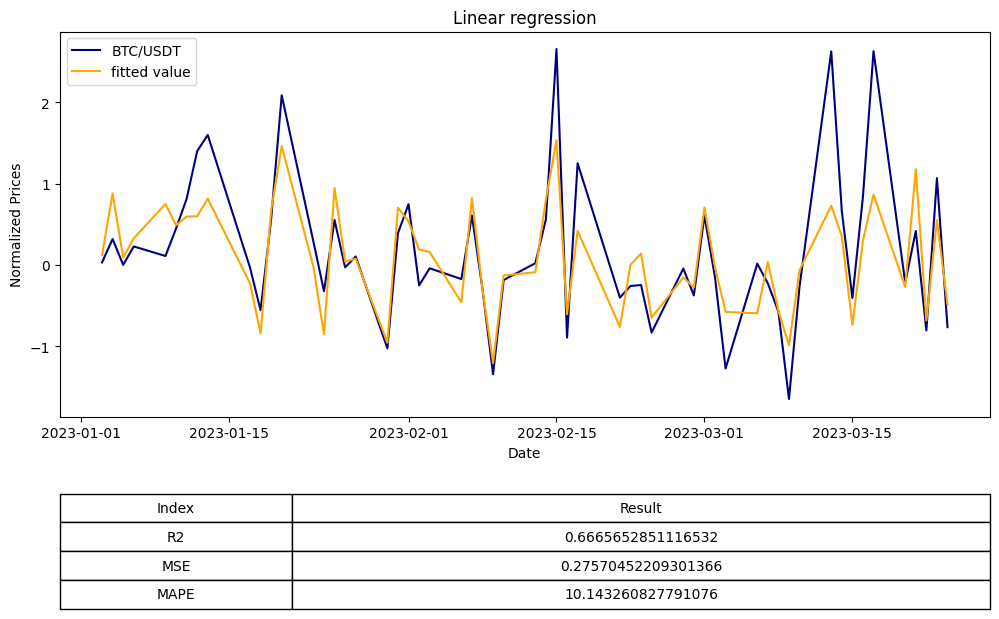

Task Complete. 


In [72]:
linreg_model = LinearRegression(fit_intercept=False)

linreg_model.fit(train_df[predictor_cols], train_df[target_col])
test_df["linreg_predicted_rate_of_return"] = linreg_model.predict(test_df[predictor_cols])
linreg_mse = MSE(test_df["linreg_predicted_rate_of_return"],test_df[target_col])
print("Learned coefficients:",linreg_model.coef_)

generate_result("Linear regression", test_df[target_col], test_df["linreg_predicted_rate_of_return"], test_df.index)

## Ridge Regression

Learned coefficients: [ 0.14109987 -0.01590422  0.00180586 -0.06540942  0.0541784  -0.06132172
 -0.01254081 -0.02210438  0.01975858 -0.00244789  0.10575376 -0.02363155
  0.06377293  0.50767847  0.07983703 -0.04626337  0.14527153  0.11037381]


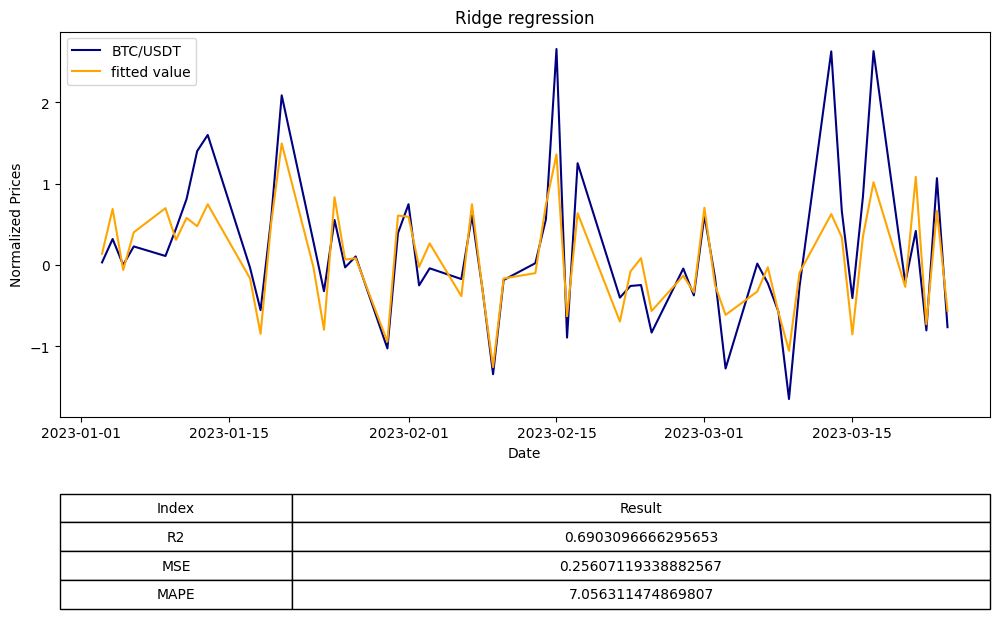

Task Complete. 


In [66]:
# Train and evaluate the ridge regression model with cross-validation
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model = Ridge(fit_intercept=False)
ridge_cv_model = GridSearchCV(estimator=ridge_model, param_grid={'alpha': alpha_range}, cv=5)
ridge_cv_model.fit(train_df[predictor_cols], train_df[target_col])
best_alpha = ridge_cv_model.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(train_df[predictor_cols], train_df[target_col])
test_df["ridge_predicted_rate_of_return"] = ridge_model.predict(test_df[predictor_cols])
ridge_mse = MSE(test_df["ridge_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",ridge_model.coef_)

generate_result("Ridge regression", test_df[target_col], test_df["ridge_predicted_rate_of_return"], test_df.index)

## Lasso Regression

Learned coefficients: [ 0.49446734  0.45425788  0.04973696 -0.54475876  0.05787996 -0.14256165
 -0.04761114  0.01568844  0.4002834  -0.28323985  0.23618006 -0.53613479
  0.05213698  0.58202023  0.09289372 -0.12578556  0.18265103  0.09005991]


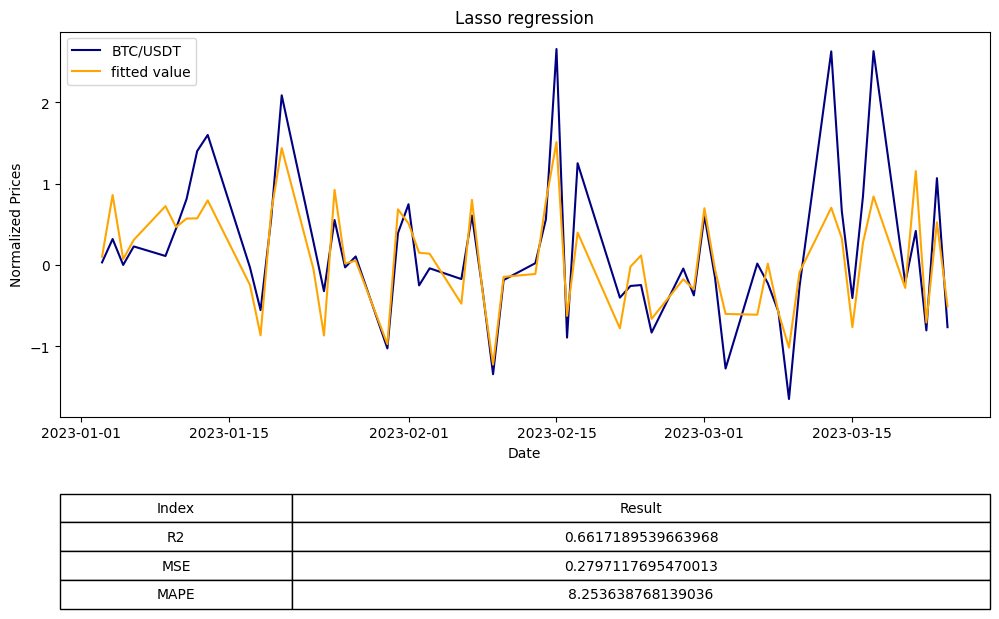

Task Complete. 


In [67]:
# Train and evaluate the ridge regression model with cross-validation
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lasso_model = Lasso(fit_intercept=False)
lasso_cv_model = GridSearchCV(estimator=lasso_model, param_grid={'alpha': alpha_range}, cv=5)
lasso_cv_model.fit(train_df[predictor_cols], train_df[target_col])
best_alpha = lasso_cv_model.best_params_['alpha']
lasso_model = Ridge(alpha=best_alpha)
lasso_model.fit(train_df[predictor_cols], train_df[target_col])
test_df["lasso_predicted_rate_of_return"] = lasso_model.predict(test_df[predictor_cols])
lasso_mse = MSE(test_df["lasso_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",lasso_model.coef_)

generate_result("Lasso regression", test_df[target_col], test_df["lasso_predicted_rate_of_return"] , test_df.index)

## Elastic Net

Learned coefficients: [ 4.79581026e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.26393798e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.76640066e-02  0.00000000e+00
  6.63462978e-02  4.46046534e-01  7.90396552e-02  1.83290400e-04
  1.29396196e-01  1.21228654e-01]


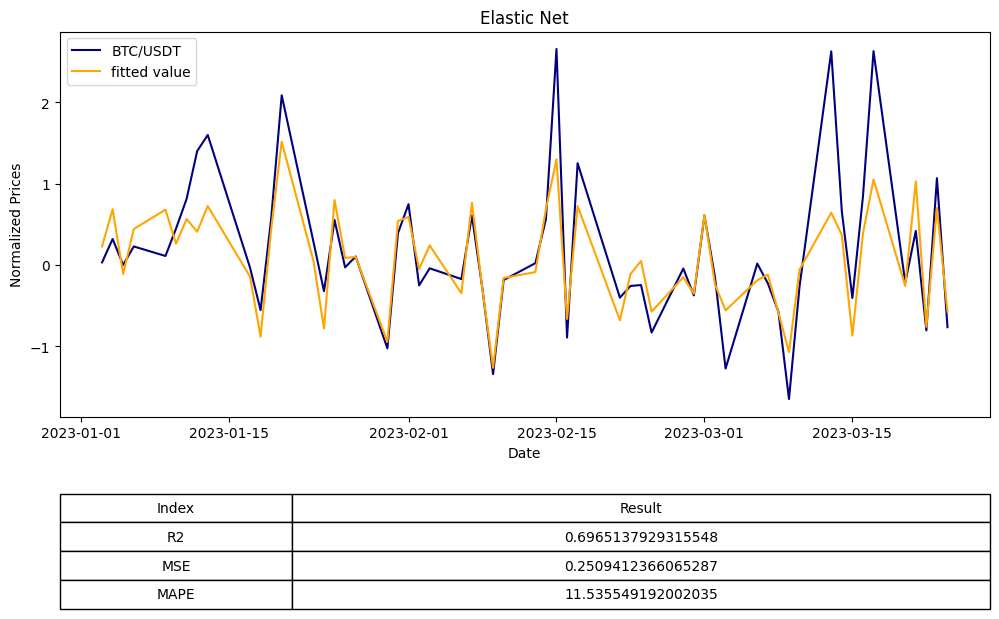

Task Complete. 


In [68]:
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
l1_ratio_range = [0.1, 0.3, 0.5, 0.7, 0.9]

# Create the Elastic Net regression model and cross-validation object
en_model = ElasticNet(fit_intercept=False)
param_grid = {'alpha': alpha_range, 'l1_ratio': l1_ratio_range}
en_cv_model = GridSearchCV(en_model, param_grid=param_grid, cv=5)

# Train the cross-validation model on the training data
en_cv_model.fit(train_df[predictor_cols], train_df[target_col])

# Get the best hyperparameter values from the cross-validation results
best_alpha = en_cv_model.best_params_['alpha']
best_l1_ratio = en_cv_model.best_params_['l1_ratio']

# Train the final Elastic Net regression model on the training data with the best hyperparameter values
en_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
en_model.fit(train_df[predictor_cols], train_df[target_col])

# Make predictions on the test data
test_df["predicted_rate_of_return"] = en_model.predict(test_df[predictor_cols])

# Evaluate the model performance on the test data
en_mse = MSE(test_df["predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",en_model.coef_)

generate_result("Elastic Net", test_df[target_col], test_df["predicted_rate_of_return"], test_df.index)

## SVR

Learned coefficients: [ 0.20411693  0.00147702 -0.0124413  -0.1680851   0.0240072  -0.10107776
 -0.0330383   0.00641988  0.05684087  0.00229057  0.12259478 -0.00277375
  0.04352036  0.46412     0.06204034 -0.00154376  0.12903113  0.13199542]


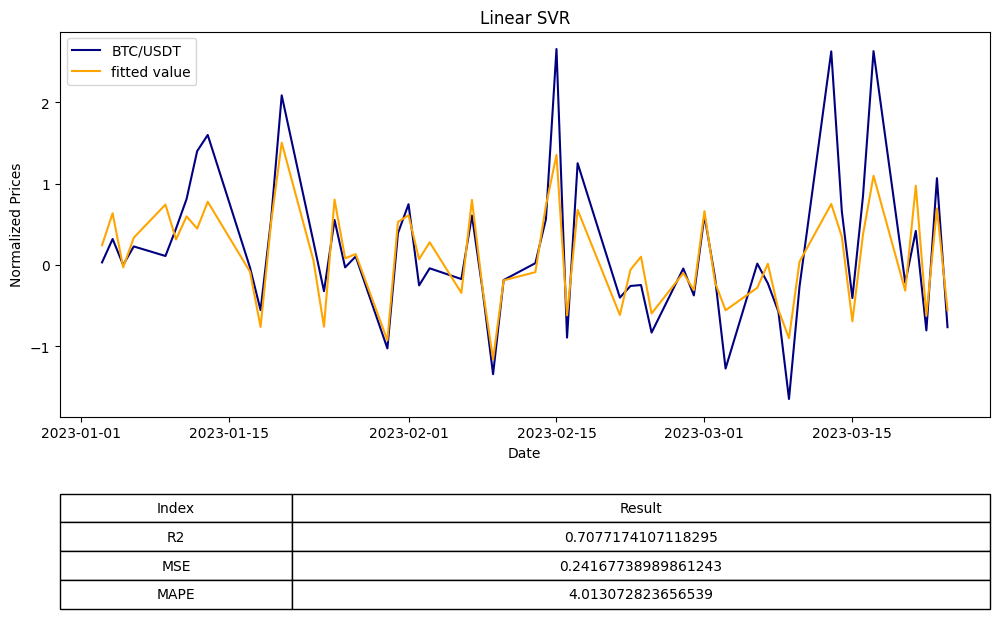

Task Complete. 


In [69]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

# Define the parameter grid to search over
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10, 100]
}

# Train a linear SVR model with cross-validation and no intercept
svr_model = LinearSVR(fit_intercept=False)
svr_cv_model = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5)
svr_cv_model.fit(train_df[predictor_cols], train_df[target_col])

# Extract the best hyperparameters and train the final model
best_C = svr_cv_model.best_params_['C']
best_epsilon = svr_cv_model.best_params_['epsilon']
svr_model = LinearSVR(C=best_C, epsilon=best_epsilon, fit_intercept=False)
svr_model.fit(train_df[predictor_cols], train_df[target_col])

# Evaluate the model on the test set
test_df["svr_predicted_rate_of_return"] = svr_model.predict(test_df[predictor_cols])
svr_mse = MSE(test_df["svr_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",svr_model.coef_)

# Generate the evaluation report
generate_result("Linear SVR", test_df[target_col], test_df["svr_predicted_rate_of_return"], test_df.index)


## SGD Regression

Learned coefficients: [ 0.08568665 -0.01877695  0.00146476 -0.0043571   0.06166162 -0.04121788
  0.00118991 -0.0103223   0.01958327  0.00449523  0.06993123 -0.00904816
  0.07057139  0.47082133  0.07935888  0.00447145  0.12271517  0.13246948]


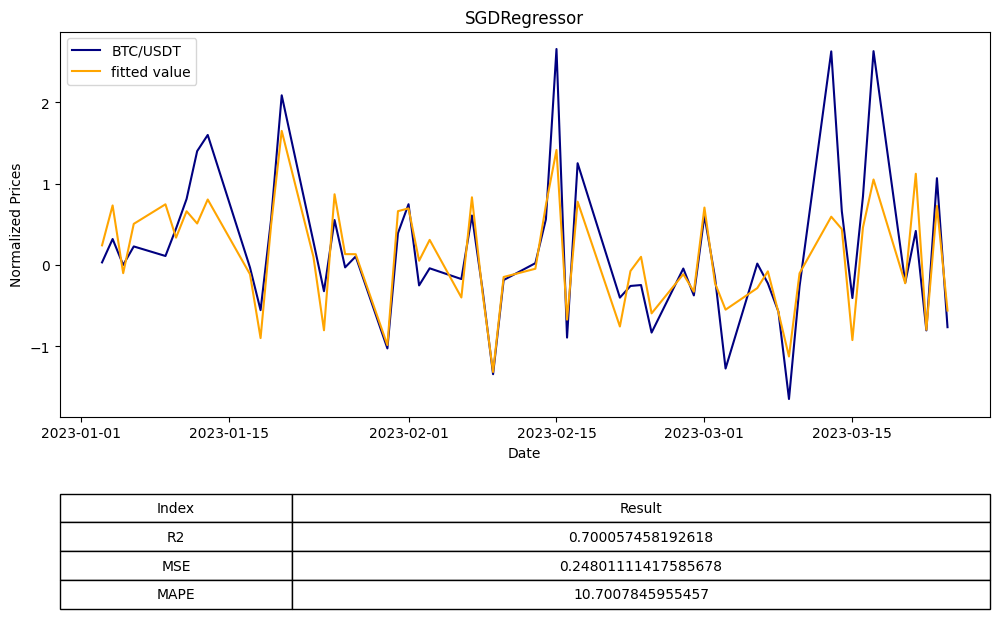

Task Complete. 


In [70]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

# Define the parameter grid to search over
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'epsilon': [0.01, 0.1, 1, 10, 100]
}

# Train an SGDRegressor model with cross-validation and no intercept
sgd_model = SGDRegressor(fit_intercept=False)
sgd_cv_model = GridSearchCV(estimator=sgd_model, param_grid=param_grid, cv=5)
sgd_cv_model.fit(train_df[predictor_cols], train_df[target_col])

# Extract the best hyperparameters and train the final model
best_alpha = sgd_cv_model.best_params_['alpha']
best_epsilon = sgd_cv_model.best_params_['epsilon']
sgd_model = SGDRegressor(alpha=best_alpha, epsilon=best_epsilon, fit_intercept=False)
sgd_model.fit(train_df[predictor_cols], train_df[target_col])

# Evaluate the model on the test set
test_df["sgd_predicted_rate_of_return"] = sgd_model.predict(test_df[predictor_cols])
sgd_mse = MSE(test_df["sgd_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:", sgd_model.coef_)

# Generate the evaluation report
generate_result("SGDRegressor", test_df[target_col], test_df["sgd_predicted_rate_of_return"], test_df.index)


## Best Subsets Selection

Best Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] Best Score: 0.8471593936408042
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Optimal set of predictor variables: ['IJS', 'IWD', 'VLUE', 'VBR', 'XSVM', 'VTV', 'QUAL', 'SIZE', 'VUG', 'VTI', 'MTUM', '^GSPC', 'DOGE_USDT_ror', 'ETH_USDT_ror', 'LINK_USDT_ror', 'DOT_USDT_ror', 'ADA_USDT_ror', 'SOL_USDT_ror']
Best Subsets Linear Regression mean squared error: 0.27570452209301366
Learned coefficients: [ 0.50021881  0.46577469  0.0526496  -0.55096913  0.05902579 -0.12786703
 -0.04446449  0.00583478  0.44216245 -0.30833806  0.2349655  -0.57186856
  0.05157245  0.58138091  0.09232037 -0.12400699  0.18351892  0.08951046]


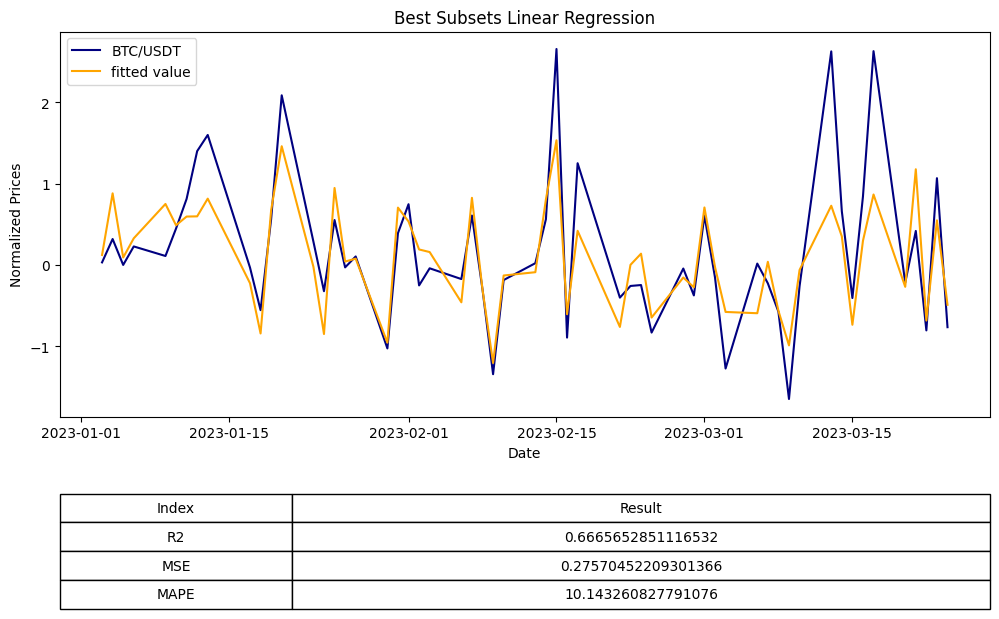

Task Complete. 


In [78]:
def best_subset_selection(X, y):
  
    # Get the number of features
    num_features = X.shape[1]
    
    # Initialize the best score and feature list
    best_score = -np.inf
    best_features = []
    
    # Loop over all possible feature combinations
    for k in range(1, num_features+1):
        for subset in itertools.combinations(range(num_features), k):
            # Train a linear regression model using the current feature subset
            model = LinearRegression(fit_intercept=False).fit(X[:, subset], y)
            score = model.score(X[:, subset], y)
            # Update the best score and feature list if necessary
            if score > best_score:
                best_score = score
                best_features = list(subset)
    print("Best Features:", best_features, "Best Score:", best_score) 
    return best_features

optimal_predictor_cols = best_subset_selection(train_df[predictor_cols].values, train_df[target_col].values)
print("Optimal set of predictor variables:", [predictor_cols[i] for i in optimal_predictor_cols])

# Train a linear regression model using the optimal set of predictor variables
B_linreg_model = LinearRegression(fit_intercept=False)
B_linreg_model.fit(train_df[predictor_cols].iloc[:, optimal_predictor_cols], train_df[target_col])

# Make predictions on the test set using the trained model
test_df["best_linreg_predicted_rate_of_return"] = B_linreg_model.predict(test_df[predictor_cols].iloc[:, optimal_predictor_cols])

# Compute the mean squared error of the predictions
print("Learned coefficients:", B_linreg_model.coef_)
generate_result("Best Subsets Linear Regression", test_df[target_col], test_df["best_linreg_predicted_rate_of_return"], test_df.index)


<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>